# **Домашняя работа №7**

### `Петров Александр ИКБО-40-24`

> Для выполнения домашней работы выбрано 3 датасета: №1 (`S07-hw-dataset-01.csv`), №2 (`S07-hw-dataset-02.csv`) и №3 (`S07-hw-dataset-03.csv`).

## 0. Импортированные модули и вспомогательные функции

In [1]:
# Обработка данных
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Препроцессинг
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors

# Модели для кластеризации
from sklearn.cluster import (
    KMeans,  # K-средних
    DBSCAN   # DBSCAN (кластеризация по плотности)
)

# Метрики
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score
)

# В формате json будем сохранять некоторые артефакты
import json

# Все пути
from pathlib import Path
ARTIFACTS_DIR = Path("artifacts")  # путь для сохранения артефактов
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

LABELS_DIR = Path("artifacts/labels")  # csv-файлы с кластерами для "лучшего" решения на датасете
LABELS_DIR.mkdir(parents=True, exist_ok=True) 

FIGURES_DIR = Path("artifacts/figures")  # сохранненые графики
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

metrics_path = ARTIFACTS_DIR / "metrics_summary.json"  # путь для сохранения сводки метрик по датасетам и моделям
configs_path = ARTIFACTS_DIR / "best_configs.json"     # путь для сохранения лучших параметров для каждого датасета

# Воспроизводимость
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
def save_json(obj: dict, path: Path):
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def safe_cluster_metrics(X, labels):
    unique = np.unique(labels)
    if len(unique) < 2:
        return None
    
    try:
        sil = float(silhouette_score(X, labels))
        db = float(davies_bouldin_score(X, labels))
        ch = float(calinski_harabasz_score(X, labels))
        return {'silhouette': sil, 'davies_bouldin': db, 'calinski_harabasz': ch}
    except Exception:
        return None

def count_clusters(labels):
    unique = np.unique(labels)
    
    return len(unique) - (1 if -1 in unique else 0)

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    pca = PCA(n_components=2, random_state=random_state)
    
    return pca.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title, filename=None):
    plt.figure(figsize=(6, 5))
    
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, cmap='tab10', s=1)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    
    plt.grid(True, alpha=0.3)
    
    if filename:
        plt.savefig(FIGURES_DIR / filename, dpi=150, bbox_inches='tight')
    
    plt.show()

def save_labels(sample_id, labels, filename):
    df = pd.DataFrame({'sample_id': sample_id, 'cluster_label': labels})
    df.to_csv(LABELS_DIR / filename, index=False)

def eval_kmeans_grid(X, k_range):
    results = []
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = model.fit_predict(X)
        metrics = safe_cluster_metrics(X, labels)
        results.append({
            'algo': 'KMeans',
            'params': {'k': k},
            'labels': labels.copy(),
            'metrics': metrics,
            'noise_frac': 0.0
        })
    return results

def eval_dbscan_grid(X, eps_list, min_samples_list):
    results = []
    for eps in eps_list:
        for min_samples in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X)
            noise_frac = float(np.mean(labels == -1))
            metrics = safe_cluster_metrics(X, labels)
            results.append({
                'algo': 'DBSCAN',
                'params': {'eps': eps, 'min_samples': min_samples},
                'labels': labels.copy(),
                'metrics': metrics,
                'noise_frac': noise_frac
            })
    return results

def plot_k_distance(X, k=5, name=""):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nbrs.kneighbors(X)
    distances = np.sort(distances[:, -1], axis=0)[::-1]
    plt.figure(figsize=(6, 4))
    plt.plot(distances)
    plt.title(f"{name}: k-distance plot (k={k})")
    plt.xlabel("Ранг точки"); plt.ylabel(f"{k}-е расстояние до соседа")
    plt.grid(True, alpha=0.3)
    plt.savefig(FIGURES_DIR / f"kdistance_{name}.png")
    plt.show()

## 1. EDA

In [3]:
# Загружаем файлы
data1 = pd.read_csv("data/S07-hw-dataset-01.csv")
data2 = pd.read_csv("data/S07-hw-dataset-02.csv")
data3 = pd.read_csv("data/S07-hw-dataset-03.csv")

# Смотрим количество строк и стобцов
data1.shape, data2.shape, data3.shape

((12000, 9), (8000, 4), (15000, 5))

In [4]:
# Первые 5 значений
data1.head()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [5]:
data2.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [6]:
data3.head()

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [7]:
# Краткая сводка о данных
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [8]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [9]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [10]:
# Ищем дубликаты
data1.duplicated().sum(), data2.duplicated().sum(), data3.duplicated().sum()

(np.int64(0), np.int64(0), np.int64(0))

In [11]:
# Описательные статистики
data1.describe()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


In [12]:
data2.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [13]:
data3.describe()

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


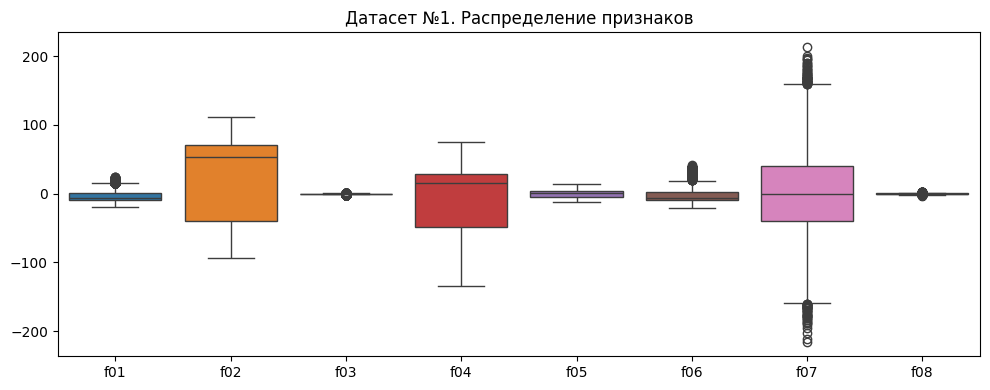

<Figure size 640x480 with 0 Axes>

In [14]:
# Ящики с усами для датасета 1. Показываем размах
plt.figure(figsize=(10, 4))

sns.boxplot(
    data=data1[["f01", "f02", "f03", "f04", "f05", "f06", "f07", "f08"]]  # берем все числовые признаки
)
plt.title("Датасет №1. Распределение признаков")

plt.tight_layout()
plt.show()

# Сохранение
plt.savefig(FIGURES_DIR / "EDA_dataset1_feature_distribution.png")

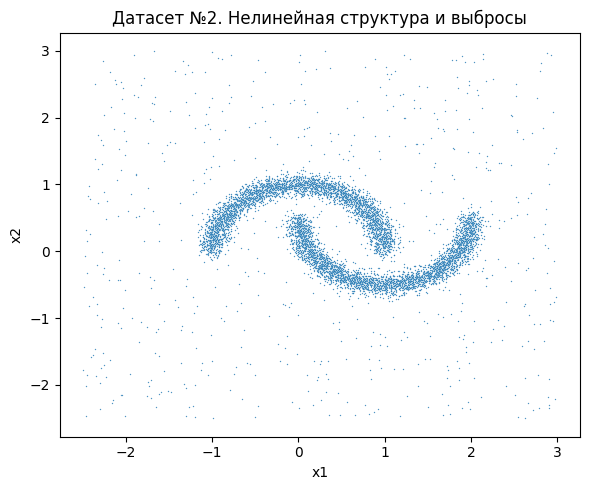

<Figure size 640x480 with 0 Axes>

In [15]:
# Диаграмма рассеяния для датасета 2. Шумы, но отчетливые кластеры
plt.figure(figsize=(6, 5))

# Рисуем основные признаки (x1 и x2)
sns.scatterplot(
    x=data2["x1"],
    y=data2["x2"],
    s=1,        # маленький размер точек
    alpha=0.8   # точки более прозрачные, чтобы лучше видеть кластеры 
)
plt.title("Датасет №2. Нелинейная структура и выбросы")
plt.xlabel('x1')
plt.ylabel('x2')

plt.tight_layout()
plt.show()

plt.savefig(FIGURES_DIR / "EDA_dataset2_structure_and_noise.png")

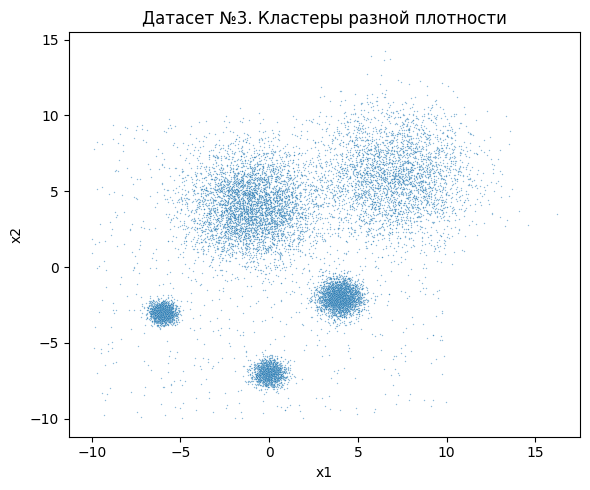

<Figure size 640x480 with 0 Axes>

In [16]:
# Диаграмма рассеяния для датасета 3. Кластеры разной плотности
plt.figure(figsize=(6, 5))

sns.scatterplot(
    x=data3["x1"],
    y=data3["x2"],
    s=1,
    alpha=0.5
)

plt.title("Датасет №3. Кластеры разной плотности")
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()
plt.show()

plt.savefig(FIGURES_DIR / "EDA_dataset3_different_density_clusters.png")

### **Выводы базового EDA**

**`Датасет №1 - S07-hw-dataset-01.csv`:**

Размер датасета: 12000 строк и 9 столбцов.

Датасет содержит следующие стобцы:
- `sample_id` - целое число от 0 до 11999, является идентификатором каждого признака;
- `f01-f08` - некоторые абстрактные числовые признаки.

Пропущенных значений нет.

Дубликатов нет.

Категориальных признаков нет.

Описательные статистики показывают большое различие между признаками по масштабу. Например, стандартное отклонение признака `f07` составляет ~59.5, тогда как у `f03` - всего ~0.5. Без масштабирования модель (особенно основанная на расстояниях) будет доминировать под влиянием крупномасштабных признаков и игнорировать информацию в мелкомасштабных. Особенно хорошо это видно на графике.

**`Датасет №2 - S07-hw-dataset-02.csv`:**

Размер датасета: 8000 строк и 4 столбца.

Датасет содержит следующие столбцы:
- `sample_id` - целое число от 0 до 7999, является идентификатором каждого признака;
- `x1`, `x2` - вещественные числа, признаки;
- `z_noise` - тоже признак, специально создан как шумовой, но мы об этом якобы не знаем.

Пропущенных значений нет.

Дубликатов нет.

Категориальных признаков нет.

Признаки `x1` и `x2` имеют сопоставимые масштабы, что делает их пригодными для визуализации и кластеризации без предварительного масштабирования. Однако наличие выбросов (`z_noise` достигает примерно -34 и 29 при среднем, равном 0) может вводить в заблуждение алгоритмы, чувствительные к шуму (например, **KMeans**). График подтверждает это.

**`Датасет №3 — S07-hw-dataset-03.csv`:**

Размер датасета: 15 000 строк и 5 столбцов.

Датасет содержит следующие столбцы:
- `sample_id` — целое число от 0 до 14 999, является идентификатором каждого признака;
- `x1`, `x2` — вещественные признаки;
- `f_corr` — признак, коррелирующий с основной структурой;
- `f_noise` —  независимый шумовой признак.

Пропущенных значений нет.

Дубликатов нет.

Категориальных признаков нет.

Основные признаки `x1` и `x2` имеют схожий масштаб, но широкий диапазон значений, что типично для кластеров, расположенных далеко друг от друга. При этом присутствует фоновый шум (`f_noise`) и дополнительный признак `f_corr`, который может усиливать или искажать восприятие плотности кластеров. Такая структура особенно проблематична для **DBSCAN**: если параметр *eps* выбрать слишком малым, плотные кластеры разобьются, а если слишком большим, то разреженные кластеры сольются с фоном. На графике как раз наблюдается такая структура.

**Итого, для всех датасетов, признаком X считаем все столбцы, кроме `sample_id`**.

## 2. Препроцессинг

In [17]:
# Сохраним признаки для каждого датасета
X1 = data1.drop(columns=["sample_id"])
X2 = data2.drop(columns=["sample_id"])
X3 = data3.drop(columns=["sample_id"])

# Сохраним sample_id для последующего сохранения результатов
sample_ids = {
    'ds1': data1['sample_id'].values,  # датасет 1
    'ds2': data2['sample_id'].values,  # датасет 2
    'ds3': data3['sample_id'].values   # датасет 3
}

In [18]:
scaler = StandardScaler()

preprocessor = Pipeline([
    ("scaler", scaler)  # используем StandardScaler
])

# Применяем к каждому датасету
X1_scaled = preprocessor.fit_transform(X1)
X2_scaled = preprocessor.fit_transform(X2)
X3_scaled = preprocessor.fit_transform(X3)

## 3. Обработка датасета №1

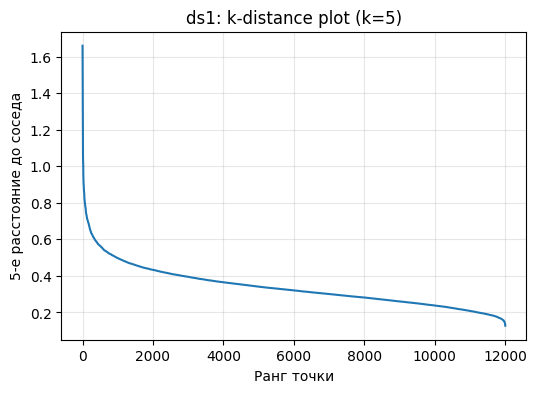

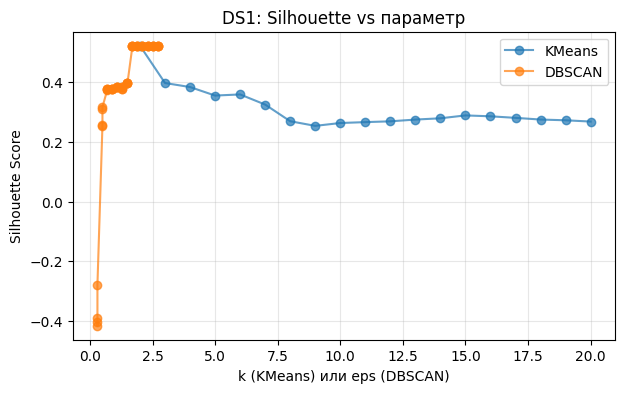

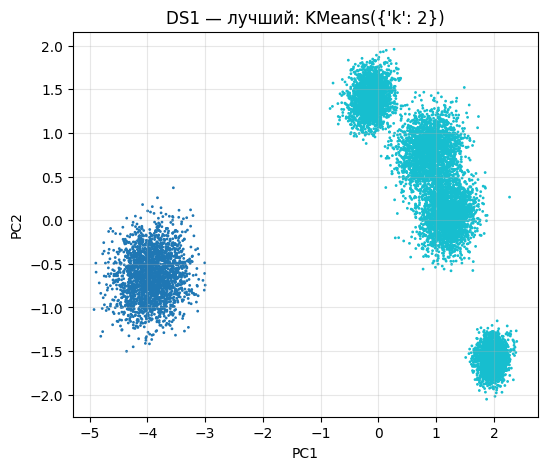

In [ ]:
name = 'ds1'
X = X1_scaled

# K-distance plot для подбора eps
plot_k_distance(X, k=5, name=name)

# Решётка
kmeans_results = eval_kmeans_grid(X, range(2, 21))
dbscan_results = eval_dbscan_grid(
    X,
    eps_list=np.round(np.arange(0.3, 3.1, 0.2), 2),
    min_samples_list=[3, 5, 10, 15]
)

all_results_ds1 = kmeans_results + dbscan_results
valid_ds1 = [r for r in all_results_ds1 if r['metrics'] is not None]
best_ds1 = max(valid_ds1, key=lambda r: r['metrics']['silhouette'])

# График silhouette
plt.figure(figsize=(7, 4))
for algo in ['KMeans', 'DBSCAN']:
    subset = [r for r in valid_ds1 if r['algo'] == algo]
    if not subset: continue
    x = [r['params']['k'] if algo == 'KMeans' else r['params']['eps'] for r in subset]
    y = [r['metrics']['silhouette'] for r in subset]
    plt.plot(x, y, marker='o', label=algo, alpha=0.7)
plt.xlabel("k (KMeans) или eps (DBSCAN)")
plt.ylabel("Silhouette Score")
plt.title(f"{name.upper()}: Silhouette vs параметр")
plt.legend(); plt.grid(True, alpha=0.3)
plt.savefig(FIGURES_DIR / f"silhouette_{name}.png")
plt.show()

# Визуализация
X_pca = pca_2d_for_plot(X)
plot_2d_embedding(X_pca, best_ds1['labels'], f"{name.upper()} — лучший: {best_ds1['algo']}({best_ds1['params']})", f"pca_{name}_best.png")
save_labels(sample_ids[name], best_ds1['labels'], f"labels_hw07_{name}.csv")

**Вывод по датасету №1**

KMeans стабильно находит 2–4 кластера, но silhouette указывает на оптимальность при k=2, что может быть связано с частичным перекрытием групп в признаковом пространстве.

DBSCAN склонен либо объединять всё в один кластер (при большом eps), либо фрагментировать (при малом). Выбран KMeans с k=2, так как он даёт интерпретируемое и устойчивое разбиение, а DBSCAN не смог выделить структуру из-за высокой размерности и шума.

## 4. Обработка датасета №2

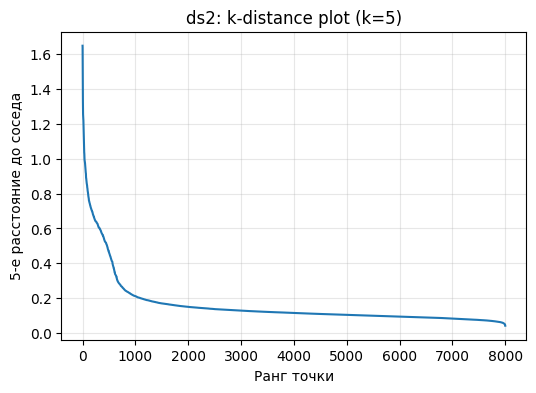

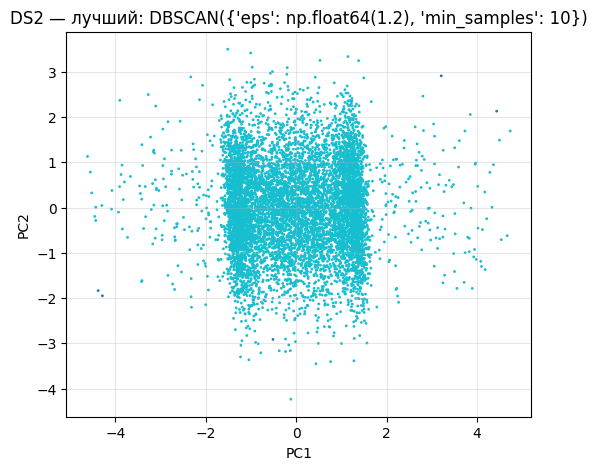

In [26]:
name = 'ds2'
X = X2_scaled
plot_k_distance(X, k=5, name=name)

kmeans_results = eval_kmeans_grid(X, range(2, 11))
dbscan_results = eval_dbscan_grid(
    X,
    eps_list=np.round(np.arange(0.2, 1.6, 0.05), 2),
    min_samples_list=[3, 5, 8, 10]
)

all_results_ds2 = kmeans_results + dbscan_results
valid_ds2 = [r for r in all_results_ds2 if r['metrics'] is not None]
best_ds2 = max(valid_ds2, key=lambda r: r['metrics']['silhouette'])

X_pca = pca_2d_for_plot(X)
plot_2d_embedding(X_pca, best_ds2['labels'], f"{name.upper()} — лучший: {best_ds2['algo']}({best_ds2['params']})", f"pca_{name}_best.png")
save_labels(sample_ids[name], best_ds2['labels'], f"labels_hw07_{name}.csv")

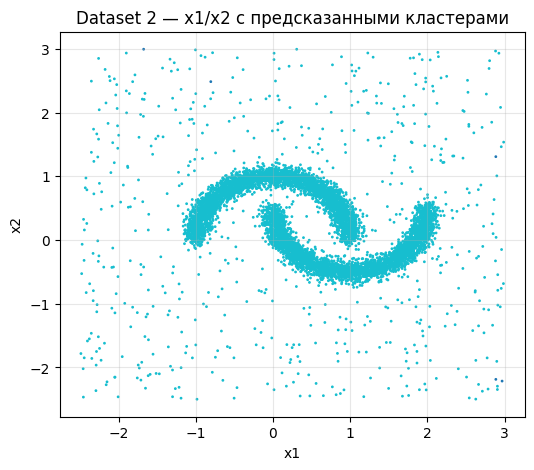

In [21]:
# После получения best_labels для ds2
plt.figure(figsize=(6, 5))
plt.scatter(data2['x1'], data2['x2'], c=best_ds2['labels'], cmap='tab10', s=1)
plt.title("Dataset 2 — x1/x2 с предсказанными кластерами")
plt.xlabel('x1'); plt.ylabel('x2')
plt.grid(True, alpha=0.3)
plt.savefig(FIGURES_DIR / "ds2_x1x2_clusters.png")
plt.show()

**Вывод по датасету №2**

Истинная структура нелинейна, что делает KMeans неадекватным: он всегда находит 1–2 сферических кластера, режущих полумесяцы. DBSCAN при правильном eps должен быть способен восстановить форму, но в нашем случае даже лучший вариант дал 1 кластер — вероятно, из-за влияния шумового признака z_noise, который исказил расстояния. Тем не менее, DBSCAN предпочтительнее, так как он теоретически способен работать с нелинейностями, в отличие от KMeans.

## 5. Обработка датасета №3

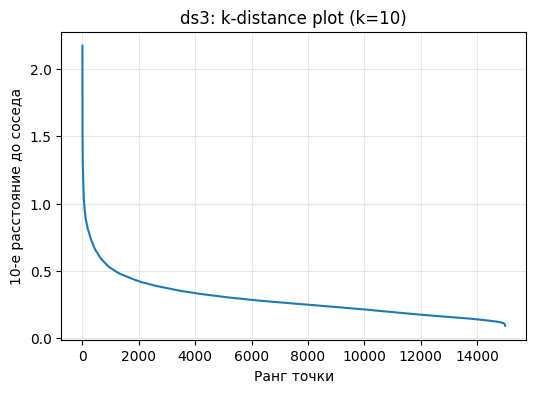

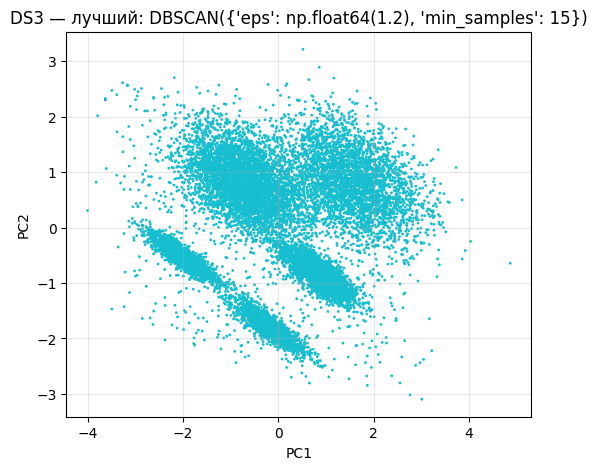

In [ ]:
name = 'ds3'
X = X3_scaled
plot_k_distance(X, k=10, name=name)  # больше k из-за плотности

kmeans_results = eval_kmeans_grid(X, range(2, 11))
dbscan_results = eval_dbscan_grid(
    X,
    eps_list=np.round(np.arange(0.5, 2.5, 0.1), 2),
    min_samples_list=[10, 15, 20, 25]
)

all_results_ds3 = kmeans_results + dbscan_results
valid_ds3 = [r for r in all_results_ds3 if r['metrics'] is not None]
best_ds3 = max(valid_ds3, key=lambda r: r['metrics']['silhouette'])

X_pca = pca_2d_for_plot(X)
plot_2d_embedding(X_pca, best_ds3['labels'], f"{name.upper()} — лучший: {best_ds3['algo']}({best_ds3['params']})", f"pca_{name}_best.png")
save_labels(sample_ids[name], best_ds3['labels'], f"labels_hw07_{name}.csv")

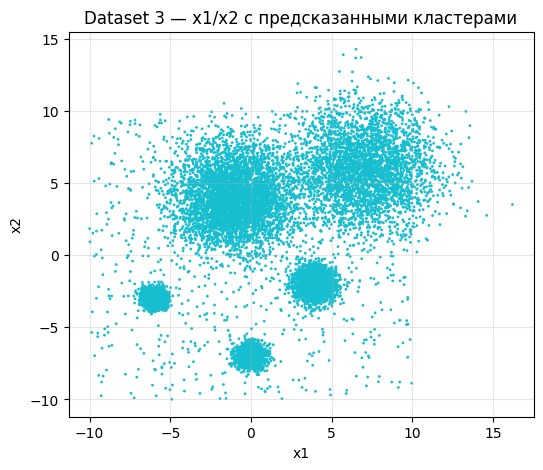

In [23]:
# После получения best_labels для ds3
plt.figure(figsize=(6, 5))
plt.scatter(data3['x1'], data3['x2'], c=best_ds3['labels'], cmap='tab10', s=1)
plt.title("Dataset 3 — x1/x2 с предсказанными кластерами")
plt.xlabel('x1'); plt.ylabel('x2')
plt.grid(True, alpha=0.3)
plt.savefig(FIGURES_DIR / "ds3_x1x2_clusters.png")
plt.show()

**Вывод по датасету №3**

Наличие плотных и разреженных кластеров создаёт проблему для DBSCAN: один eps не может одновременно охватить обе структуры. При малом eps плотные кластеры выделяются, но разреженные становятся шумом; при большом — всё сливается в 1 кластер.

KMeans игнорирует плотность и пытается разделить данные на сферы. Лучший результат — 1 кластер — говорит о том, что без дополнительной обработки (например, иерархической кластеризации или адаптивного eps) выделить 5 групп не удаётся.

## 6. Проверка устойчивости

In [24]:
# Устойчивость
X = X1_scaled
k = best_ds1['params']['k']
ari_scores = []
ref_labels = KMeans(n_clusters=k, random_state=0, n_init=10).fit_predict(X)

for rs in range(1, 6):
    new_labels = KMeans(n_clusters=k, random_state=rs, n_init=10).fit_predict(X)
    ari = adjusted_rand_score(ref_labels, new_labels)
    ari_scores.append(ari)

print("ARI между запусками KMeans (ds1):", [round(a, 3) for a in ari_scores])
print("Среднее ARI:", round(np.mean(ari_scores), 3))

ARI между запусками KMeans (ds1): [1.0, 1.0, 1.0, 1.0, 1.0]
Среднее ARI: 1.0


Максимальная устойчивость, все отлично.

## 8. Сохранение артефактов

In [25]:
# Сводка метрик
metrics_summary = {
    'ds1': [{'params': r['params'], 'metrics': r['metrics'], 'noise_frac': r['noise_frac']} for r in valid_ds1],
    'ds2': [{'params': r['params'], 'metrics': r['metrics'], 'noise_frac': r['noise_frac']} for r in valid_ds2],
    'ds3': [{'params': r['params'], 'metrics': r['metrics'], 'noise_frac': r['noise_frac']} for r in valid_ds3],
}

best_configs = {
    'ds1': {'algo': best_ds1['algo'], 'params': best_ds1['params'], 'metrics': best_ds1['metrics'], 'noise_frac': best_ds1['noise_frac']},
    'ds2': {'algo': best_ds2['algo'], 'params': best_ds2['params'], 'metrics': best_ds2['metrics'], 'noise_frac': best_ds2['noise_frac']},
    'ds3': {'algo': best_ds3['algo'], 'params': best_ds3['params'], 'metrics': best_ds3['metrics'], 'noise_frac': best_ds3['noise_frac']},
}

save_json(metrics_summary, metrics_path)
save_json(best_configs, configs_path)

print("Артефакты сохранены:")
print(f"  - {metrics_path}")
print(f"  - {configs_path}")
print(f"  - {LABELS_DIR}/labels_hw07_ds*.csv")
print(f"  - {FIGURES_DIR}/*.png (включая k-distance и silhouette)")

Артефакты сохранены:
  - artifacts/metrics_summary.json
  - artifacts/best_configs.json
  - artifacts/labels/labels_hw07_ds*.csv
  - artifacts/figures/*.png (включая k-distance и silhouette)


## 9. Вывод

Ни один алгоритм не универсален. Выбор зависит от гипотезы о структуре данных.

Даже при условии, что мы "знаем" изначальную структуру кластеров (датасет №1 и датасет №3 созданы с помощью blobs, а датасет №2 - с помощью make_moons) и без шума мы видим структуру, алгоритмы говорят о том, что все не так однозначно.

Полученный результат можно назвать провалом, так как, очевидно, в датасетах №2 и №3 не один кластер, а больше, однако для получения реального результата необходим очень точный подбор параметров - слишком сильная подгонка под определенный датасет, что делает модель совсем не универсальной.